# GEOSPATIAL ANALYSIS OF VEGETABLE IMPORTS TO DENMARK AND THEIR IMPACT ON CO2 EMISSIONS

## DATA PREPARATION NOTEBOOK

This notebook prepares and consolidates vegetable import data from Statistics Denmark.  
It includes data loading, cleaning, merging across years, and a basic visualization example.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import glob

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


# 1. VEGETABLE IMPORTS DATA

https://www.statbank.dk/KN8Y - veggies data: focus on vegetable categories (e.g., HS_Code 0701–0714)


## Data Loading & Cleaning

The following section reads raw files, applies transformations.

In [2]:
# Load the world shapefile
shapefile_path = "data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)

# csv path
folder_path = "data/"  

# Find all CSV files 
csv_files = glob.glob(f"{folder_path}/StatisticsDenmark*.csv")

dataframes = {}

for file in csv_files:
    # Extract period and year from the filename
    filename = file.split("/")[-1]  # Get only the filename (remove path)
    parts = filename.replace("StatisticsDenmark", "").replace(".csv", "").split("_")
    
    if len(parts) == 3:  # Ensuring we have both period and year
        period, subperiod, year = parts
        key = f"{period}_{subperiod}_{year}"  # Example: "0701_09_2023"
    else:
        year = parts[-1]
        key = year

    try:
        df = pd.read_csv(file, encoding="ISO-8859-1")
    except UnicodeDecodeError:
        df = pd.read_csv(file, encoding="utf-8")
    
    dataframes[key] = df




In [3]:
dataframes['0701_09_2023']

,Import,2023,07011000 Læggekartofler,I alt,2061912,8409758,0
0,Import,2023,07011000 Læggekartofler,Afghanistan,0,0,0
1,Import,2023,07011000 Læggekartofler,Albanien,0,0,0
2,Import,2023,07011000 Læggekartofler,Algeriet,0,0,0
3,Import,2023,07011000 Læggekartofler,Amerikansk Oceanien,0,0,0
4,Import,2023,07011000 Læggekartofler,Amerikansk Samoa,0,0,0
...,...,...,...,...,...,...,...
32835,Import,2023,"07099990 Grøntsager, fersk/kølet, i.a.n.",Østrig,0,0,0
32836,Import,2023,"07099990 Grøntsager, fersk/kølet, i.a.n.",Diskretioneret,0,0,0
32837,Import,2023,"07099990 Grøntsager, fersk/kølet, i.a.n.",Uoplyst land,0,0,0
32838,Import,2023,"07099990 Grøntsager, fersk/kølet, i.a.n.",Uoplyst land EU-lande,0,0,0


In [4]:
# Define the columns to drop
drop_columns = ["0"]

# Apply transformations to each DataFrame
for key, df in dataframes.items():
    
    # rename columns based on position
    column_names = df.columns.tolist()
    if len(column_names) >= 6:
        rename_map = {
            column_names[1]: "Year",
            column_names[3]: "Country",
            column_names[4]: "KG",
            column_names[5]: "DKK"
        }
        df = df.rename(columns=rename_map)

    # Drop unnecessary columns
    df = df.drop(columns=drop_columns, errors="ignore")


    # Identify the commodity column (the first unknown column — now index 2)
    if len(df.columns) > 2:
        commodity_col = df.columns[2]
        
        # Check if it’s a Series
        if pd.api.types.is_string_dtype(df[commodity_col]):
            df["HS_Code"] = df[commodity_col].str.split(" ", n=1).str[0]
            df["Commodity_Name"] = df[commodity_col].str.split(" ", n=1).str[1]
        
        # Drop original commodity column
        df = df.drop(columns=[commodity_col])

    # Store cleaned DataFrame
    dataframes[key] = df


In [5]:
dataframes['0701_09_2022']

,Import,Year,Country,KG,DKK,HS_Code,Commodity_Name
0,Import,2022,Afghanistan,0,0,07011000,Læggekartofler
1,Import,2022,Albanien,0,0,07011000,Læggekartofler
2,Import,2022,Algeriet,0,0,07011000,Læggekartofler
3,Import,2022,Amerikansk Oceanien,0,0,07011000,Læggekartofler
4,Import,2022,Amerikansk Samoa,0,0,07011000,Læggekartofler
...,...,...,...,...,...,...,...
32835,Import,2022,Østrig,428,9707,07099990,"Grøntsager, fersk/kølet, i.a.n."
32836,Import,2022,Diskretioneret,0,0,07099990,"Grøntsager, fersk/kølet, i.a.n."
32837,Import,2022,Uoplyst land,0,0,07099990,"Grøntsager, fersk/kølet, i.a.n."
32838,Import,2022,Uoplyst land EU-lande,0,0,07099990,"Grøntsager, fersk/kølet, i.a.n."


## 1.1 Yearly Data Concatenation

All yearly dataframes are vertically concatenated into a single dataframe

In [6]:
# Combine both 0701_09 and 0710_14 datasets - each year
merged_df = pd.concat(
    [df for key, df in dataframes.items() if key.startswith(("0701_09_", "0710_14_"))],
    ignore_index=True
)
merged_df[38000:]

,Import,Year,Country,KG,DKK,HS_Code,Commodity_Name
38000,Import,2021,Guadeloupe,0,0,07031019,"Spiseløg, friske eller kølede (undtagen i form..."
38001,Import,2021,Guam,0,0,07031019,"Spiseløg, friske eller kølede (undtagen i form..."
38002,Import,2021,Guatemala,0,0,07031019,"Spiseløg, friske eller kølede (undtagen i form..."
38003,Import,2021,Guinea,0,0,07031019,"Spiseløg, friske eller kølede (undtagen i form..."
38004,Import,2021,Guinea-Bissau,0,0,07031019,"Spiseløg, friske eller kølede (undtagen i form..."
...,...,...,...,...,...,...,...
237083,Import,2023,Østrig,0,0,07149090,Jordskokker og lignende rødder og rodknolde me...
237084,Import,2023,Diskretioneret,0,0,07149090,Jordskokker og lignende rødder og rodknolde me...
237085,Import,2023,Uoplyst land,0,0,07149090,Jordskokker og lignende rødder og rodknolde me...
237086,Import,2023,Uoplyst land EU-lande,0,0,07149090,Jordskokker og lignende rødder og rodknolde me...


In [7]:
# Define statistical/non-geographic categories
stat_categories = [
    "Diskretioneret",
    "Uoplyst land",
    "Uoplyst land EU-lande",
    "Uoplyst land 3. Lande",
    "I alt"
]

# Create a separate DataFrame for these categories
stat_df = merged_df[merged_df["Country"].isin(stat_categories)]

# Remove them from the original DataFrame
merged_df = merged_df[~merged_df["Country"].isin(stat_categories)]

# Save the cleaned datasets
stat_df.to_csv("data/veggies_stat_categories.csv", index=False)
merged_df.to_csv("data/veggies_cleaned.csv", index=False)

# Display statistics for Kg and DKK in the stat_df
stat_summary = stat_df.groupby("Country")[["KG", "DKK"]].sum()
print(stat_summary)


                               DKK
Country                           
Diskretioneret                   0
I alt                  15999167295
Uoplyst land                     0
Uoplyst land 3. Lande       246470
Uoplyst land EU-lande            0


# 2. HS CODES

**World Customs Organization (WCO) – HS System**

The Harmonized Commodity Description and Coding System generally referred to as "Harmonized System" or simply "HS" is a multipurpose international product nomenclature developed by the World Customs Organization (WCO)

**Combined Nomenclature (CN) is the EU version of the HS system:**

https://www.dst.dk/en/Statistik/dokumentation/nomenklaturer/kn 

The Combined Nomenclature (CN) is the EU Product Nomenclature, which meets the requirements for foreign trade statistics. The Nomenclature, which is specifically addressed to information providers in intra-EU trade, contains the complete CN (without duty rates) and the associated additional units.

In [8]:
hs_path = 'data/HS_code/VegetableProductsNomenkalturer_csv_en.csv'

import pandas as pd

# Replace 'filename.csv' with your actual path
df = pd.read_csv(hs_path, 
                 sep=';', 
                 quotechar='"', 
                 encoding='utf-8',
                 dtype=str)  # keep all data as strings for HS codes
df['CODE'] = df['CODE'].astype(str).str.replace(' ', '')
df.head()


,SEQUENCE,CODE,LEVEL,TITLE,GENERAL_NOTES,INCLUDES,ALSO_INCLUDES,EXCLUDES,CASELAW,UNITOFMEASURE
0,1,I,1,"SECTION I, LIVE ANIMALS; ANIMAL PRODUCTS",NaN,NaN,NaN,NaN,NaN,NaN
1,2,01,2,CHAPTER 1: LIVE ANIMALS,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0101,3,"Live horses, asses, mules and hinnies",NaN,NaN,NaN,NaN,NaN,NaN
3,4,010121,4,Pure-bred breeding horses,NaN,NaN,NaN,NaN,NaN,NaN
4,5,01012100,5,Pure-bred breeding horses,NaN,NaN,NaN,NaN,NaN,NaN


### 2.2 Add Level 4 and 5 titles (english) to vegetable imports data

In [9]:
# --- LEVEL 5 ---
# Full 8-digit CN code

# Map from CODE to TITLE at 8-digit level
hs_level5_map = df[df['LEVEL'] == '5'].set_index('CODE')['TITLE'].to_dict()
merged_df['Commodity_Name(english)'] = merged_df['HS_Code'].map(hs_level5_map)

# --- LEVEL 4 ---
# Get first 6 digits
merged_df['HS_Code_Level4'] = merged_df['HS_Code'].str[:6]
# Map from CODE to TITLE at 6-digit level
hs_level4_map = df[df['LEVEL'] == '4'].set_index('CODE')['TITLE'].to_dict()
merged_df['HS_Level4_Product'] = merged_df['HS_Code_Level4'].map(hs_level4_map)



merged_df.tail() 

,Import,Year,Country,KG,DKK,HS_Code,Commodity_Name,Commodity_Name(english),HS_Code_Level4,HS_Level4_Product
237079,Import,2023,Zambia,0,0,07149090,Jordskokker og lignende rødder og rodknolde me...,Jerusalem artichokes and similar roots and tub...,071490,"Arrowroot, salep, Jerusalem artichokes and sim..."
237080,Import,2023,Zimbabwe,0,0,07149090,Jordskokker og lignende rødder og rodknolde me...,Jerusalem artichokes and similar roots and tub...,071490,"Arrowroot, salep, Jerusalem artichokes and sim..."
237081,Import,2023,Ækvatorialguinea,0,0,07149090,Jordskokker og lignende rødder og rodknolde me...,Jerusalem artichokes and similar roots and tub...,071490,"Arrowroot, salep, Jerusalem artichokes and sim..."
237082,Import,2023,Østtimor,0,0,07149090,Jordskokker og lignende rødder og rodknolde me...,Jerusalem artichokes and similar roots and tub...,071490,"Arrowroot, salep, Jerusalem artichokes and sim..."
237083,Import,2023,Østrig,0,0,07149090,Jordskokker og lignende rødder og rodknolde me...,Jerusalem artichokes and similar roots and tub...,071490,"Arrowroot, salep, Jerusalem artichokes and sim..."


### 2.1 Create descriptive columns by levels in english

In [10]:
# Filter for vegetable-related codes (start with '07')
veg_df = df[df['CODE'].astype(str).str.startswith('07', na=False)]

# Print all LEVEL 2 entries (Chapter level)
print("=== LEVEL 2: Chapter ===")
print(veg_df[veg_df['LEVEL'] == '2'][['CODE', 'TITLE']], end="\n\n")

# Print all LEVEL 3 entries (4-digit HS headings)
print("=== LEVEL 3: 4-digit HS Codes ===")
print(veg_df[veg_df['LEVEL'] == '3'][['CODE', 'TITLE']], end="\n\n")



=== LEVEL 2: Chapter ===
     CODE                                              TITLE
1456   07  CHAPTER 7: EDIBLE VEGETABLES AND CERTAIN ROOTS...

=== LEVEL 3: 4-digit HS Codes ===
      CODE                                              TITLE
1457  0701                         Potatoes, fresh or chilled
1464  0702                         Tomatoes, fresh or chilled
1467  0703  Onions, shallots, garlic, leeks and other alli...
1476  0704  Cabbages, cauliflowers, kohlrabi, kale and sim...
1485  0705  Lettuce "Lactuca sativa" and chicory "Cichoriu...
1494  0706  Carrots, turnips, salad beetroot, salsify, cel...
1501  0707           Cucumbers and gherkins, fresh or chilled
1505  0708  Leguminous vegetables, shelled or unshelled, f...
1512  0709  Other vegetables, fresh or chilled (excl. pota...
1555  0710  Vegetables, uncooked or cooked by steaming or ...
1580  0711  Vegetables provisionally preserved, e.g. by su...
1597  0712  Dried vegetables, whole, cut, sliced, broken o...
1617  0713  

In [11]:
import numpy as np

# Extract 4-digit HS heading
merged_df['HS_Code_Level3'] = merged_df['HS_Code'].astype(str).str[:4]

# Assign fresh/processed subcategories based on HS Level 3 codes
merged_df['Form'] = np.select(
    [
        merged_df['HS_Code_Level3'].between('0701', '0709'),
        merged_df['HS_Code_Level3'] == '0710',
        merged_df['HS_Code_Level3'] == '0711',
        merged_df['HS_Code_Level3'].isin(['0712', '0713']),
        merged_df['HS_Code_Level3'] == '0714'
    ],
    [
        'Fresh',
        'Frozen',
        'Preserved',
        'Dried',
        'Fresh'  # Starchy roots like manioc are fresh
    ],
    default='Unknown'
)
merged_df.head()

,Import,Year,Country,KG,DKK,HS_Code,Commodity_Name,Commodity_Name(english),HS_Code_Level4,HS_Level4_Product,HS_Code_Level3,Form
0,Import,2020,Afghanistan,0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,0701,Fresh
1,Import,2020,Albanien,0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,0701,Fresh
2,Import,2020,Algeriet,0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,0701,Fresh
3,Import,2020,Amerikansk Oceanien,0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,0701,Fresh
4,Import,2020,Amerikansk Samoa,0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,0701,Fresh


##### check values

In [12]:
# Drop rows with missing English commodity names
merged_df = merged_df.dropna(subset=['Commodity_Name(english)'])

# Optional: Confirm result
print(f" Remaining rows after deletion: {len(merged_df)}")


 Remaining rows after deletion: 120520


In [13]:
# Group by year and count unique entries for multiple columns
unique_counts = (
    merged_df
    .groupby('Year')
    .agg({
        'Commodity_Name(english)': 'nunique',
        'Commodity_Name': 'nunique',
        'Form': 'nunique',
        'HS_Level4_Product': 'nunique'
    })
    .rename(columns={
        'Commodity_Name(english)': 'Unique_English_Names',
        'Commodity_Name': 'Unique_Danish_Names',
        'Form': 'Unique_Forms',
        'HS_Level4_Product': 'Unique_Products'
    })
    .reset_index()
)

print(unique_counts)


   Year  Unique_English_Names  Unique_Danish_Names  Unique_Forms  \
0  2020                   115                  115             4   
1  2021                   115                  115             4   
2  2022                   115                  115             4   
3  2023                   115                  115             4   

   Unique_Products  
0               73  
1               73  
2               73  
3               73  


# 3. GLOBAL GEOGRAPHIC DATA

https://www.naturalearthdata.com/downloads/110m-cultural-vectors/ - Borders and geographic features

In [14]:
# Load the world shapefile
world = gpd.read_file(shapefile_path)

# Keep only relevant columns
world = world[["ADMIN", "ISO_A3", "POP_EST", "GDP_MD", "CONTINENT", "REGION_UN", "SUBREGION", "geometry"]]
world.head()

,ADMIN,ISO_A3,POP_EST,GDP_MD,CONTINENT,REGION_UN,SUBREGION,geometry
0,Fiji,FJI,889953.0,5496,Oceania,Oceania,Melanesia,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,58005463.0,63177,Africa,Africa,Eastern Africa,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,ESH,603253.0,907,Africa,Africa,Northern Africa,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,37589262.0,1736425,North America,Americas,Northern America,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,328239523.0,21433226,North America,Americas,Northern America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


# 3. Merging Geographic and Statistical Data

This join uses a common key: country names.  

The resulting GeoDataFrame can be used for map-based visualizations and spatial operations.

#### map danish country names to english in Vegetable Import Dataset

In [15]:
#Thank You ChatGPT :-D
country_map = {
    "Afghanistan": "Afghanistan",
    "Albanien": "Albania",
    "Algeriet": "Algeria",
    "Amerikansk Samoa": "American Samoa",
    "Amerikanske Jomfruøer": "United States Virgin Islands",
    "Andorra": "Andorra",
    "Angola": "Angola",
    "Anguilla": "Anguilla",
    "Antarktis": "Antarctica",
    "Antigua og Barbuda": "Antigua and Barbuda",
    "Argentina": "Argentina",
    "Armenien": "Armenia",
    "Aruba": "Aruba",
    "Aserbajdsjan": "Azerbaijan",
    "Australien": "Australia",
    "Bahamas": "The Bahamas",
    "Bahrain": "Bahrain",
    "Bangladesh": "Bangladesh",
    "Barbados": "Barbados",
    "Belgien": "Belgium",
    "Belize": "Belize",
    "Benin": "Benin",
    "Bermuda": "Bermuda",
    "Bhutan": "Bhutan",
    "Bolivia": "Bolivia",
    "Bosnien-Hercegovina": "Bosnia and Herzegovina",
    "Botswana": "Botswana",
    "Bouvetøen": "Bouvet Island",
    "Brasilien": "Brazil",
    "Britiske territorium i det Indiske Ocean": "British Indian Ocean Territory",
    "Brunei": "Brunei",
    "Bulgarien": "Bulgaria",
    "Burkina Faso": "Burkina Faso",
    "Burundi": "Burundi",
    "Cambodja": "Cambodia",
    "Cameroun": "Cameroon",
    "Canada": "Canada",
    "Centralafrikanske Republik": "Central African Republic",
    "Chile": "Chile",
    "Colombia": "Colombia",
    "Congo, Republikken": "Republic of the Congo",
    "Congo, Demokratiske Republik": "Democratic Republic of the Congo",
    "Cookøerne": "Cook Islands",
    "Costa Rica": "Costa Rica",
    "Cuba": "Cuba",
    "Curacao": "Curaçao",
    "Cypern": "Cyprus",
    "Dominikanske Republik": "Dominican Republic",
    "Djibouti": "Djibouti",
    "Dominica": "Dominica",
    "Ecuador": "Ecuador",
    "Egypten": "Egypt",
    "El Salvador": "El Salvador",
    "Elfenbenskysten": "Ivory Coast",
    "Eritrea": "Eritrea",
    "Estland": "Estonia",
    "Etiopien": "Ethiopia",
    "Falklandsøerne": "Falkland Islands",
    "Fiji": "Fiji",
    "Filippinerne": "Philippines",
    "Finland": "Finland",
    "Forenede Arabiske Emirater": "United Arab Emirates",
    "Frankrig og Monaco": "France",
    "Franske besiddelser i det sydlige Indiske Ocean": "French Southern and Antarctic Lands",
    "Gabon": "Gabon",
    "Gambia": "Gambia",
    "Georgien": "Georgia",
    "Ghana": "Ghana",
    "Gibraltar": "Gibraltar",
    "Grækenland": "Greece",
    "Grønland": "Greenland",
    "Guatemala": "Guatemala",
    "Guinea": "Guinea",
    "Guinea-Bissau": "Guinea-Bissau",
    "Guyana": "Guyana",
    "Haiti": "Haiti",
    "Heard- og McDonaldøerne": "Heard Island and McDonald Islands",
    "Honduras": "Honduras",
    "Hongkong": "Hong Kong",
    "Belarus": "Belarus",
    "Indien": "India",
    "Indonesien": "Indonesia",
    "Irak": "Iraq",
    "Iran": "Iran",
    "Irland": "Ireland",
    "Island": "Iceland",
    "Israel": "Israel",
    "Italien": "Italy",
    "Jamaica": "Jamaica",
    "Japan": "Japan",
    "Jordan": "Jordan",
    "Kap Verde": "Cape Verde",
    "Kasakhstan": "Kazakhstan",
    "Kenya": "Kenya",
    "Kina": "China",
    "Kirgisistan": "Kyrgyzstan",
    "Kosovo": "Kosovo",
    "Kroatien": "Croatia",
    "Kuwait": "Kuwait",
    "Laos": "Laos",
    "Lesotho": "Lesotho",
    "Letland": "Latvia",
    "Libanon": "Lebanon",
    "Liberia": "Liberia",
    "Libyen": "Libya",
    "Litauen": "Lithuania",
    "Luxembourg": "Luxembourg",
    "Macao": "Macau",
    "Madagaskar": "Madagascar",
    "Nordmakedonien": "North Macedonia",
    "Malawi": "Malawi",
    "Malaysia": "Malaysia",
    "Mali": "Mali",
    "Marokko": "Morocco",
    "Mauritanien": "Mauritania",
    "Mauritius": "Mauritius",
    "Mexico": "Mexico",
    "Moldova": "Moldova",
    "Mongoliet": "Mongolia",
    "Montenegro": "Montenegro",
    "Mozambique": "Mozambique",
    "Myanmar": "Myanmar",
    "Namibia": "Namibia",
    "Nepal": "Nepal",
    "New Zealand": "New Zealand",
    "Nederlandene": "Netherlands",
    "Nicaragua": "Nicaragua",
    "Niger": "Niger",
    "Nigeria": "Nigeria",
    "Nordkorea": "North Korea",
    "Norge": "Norway",
    "Oman": "Oman",
    "Pakistan": "Pakistan",
    "Panama": "Panama",
    "Papua Ny Guinea": "Papua New Guinea",
    "Paraguay": "Paraguay",
    "Peru": "Peru",
    "Polen": "Poland",
    "Portugal": "Portugal",
    "Qatar": "Qatar",
    "Rumænien": "Romania",
    "Rusland": "Russia",
    "Rwanda": "Rwanda",
    "Sydafrika": "South Africa",
    "Sverige": "Sweden",
    "Schweiz": "Switzerland",
    "Spanien": "Spain",
    "Tanzania": "United Republic of Tanzania",
    "Thailand": "Thailand",
    "Togo": "Togo",
    "Tyrkiet": "Turkey",
    "Tyskland": "Germany",
    "Uganda": "Uganda",
    "Ukraine": "Ukraine",
    "Ungarn": "Hungary",
    "USA": "United States of America",
    "Venezuela": "Venezuela",
    "Vietnam": "Vietnam",
    "Zimbabwe": "Zimbabwe",
    "Østrig": "Austria",
    "Serbien": "Republic of Serbia",
    "Slovakiet": "Slovakia",
    "Slovenien": "Slovenia",
    "Storbritannien": "United Kingdom",
    "Eswantini": "eSwatini",
    "Sydkorea": "South Korea",
    "Sydsudan": "South Sudan",
    "Syrien": "Syria",
    "Tadsjikistan": "Tajikistan",
    "Tchad": "Chad",
    "Tjekkiet": "Czechia",
    "Tunesien": "Tunisia",
    "Usbekistan": "Uzbekistan",
    "Vatikanstaten": "Vatican City",
    "Vestsahara": "Western Sahara",
    "Ækvatorialguinea": "Equatorial Guinea",
    "Østtimor": "East Timor",
    "Salomonøerne": "Solomon Islands",
    "Ny Kaledonien": "New Caledonia",
    'Saudi-Arabien': 'Saudi Arabia',
    'Senegal': 'Senegal',
    'Sierra Leone': 'Sierra Leone',
    'Somalia': 'Somalia',
    'Sri Lanka': 'Sri Lanka',
    'Sudan': 'Sudan',
    'Suriname': 'Suriname',
    'Taiwan': 'Taiwan',
    'Trinidad og Tobago': 'Trinidad and Tobago',
    'Turkmenistan': 'Turkmenistan',
    'Uruguay': 'Uruguay',
    'Vanuatu': 'Vanuatu',
    'Yemen': 'Yemen',
    'Zambia': 'Zambia',
    'Vestbredden og Gaza': 'Palestine',  # West Bank and Gaza corresponds to Palestine
    'Færøerne': 'Denmark',  # Faroe Islands are part of Denmark
    
    
    
    
    'Amerikansk Oceanien': 'United States of America',
    'Amerikansk Samoa': 'United States of America',
    'Amerikanske Jomfruøer': 'United States of America',
    'Andorra': 'Andorra',
    'Anguilla': 'United Kingdom',
    'Antigua og Barbuda': 'Antigua and Barbuda',
    'Aruba': 'Netherlands',
    'Australsk Oceanien': 'Australia',
    'Bahrain': 'Bahrain',
    'Barbados': 'Barbados',
    'Bermuda': 'United Kingdom',
    'Bonaire, Sint Eustatius og Saba': 'Netherlands',
    'Bouvetøen': 'Norway',
    'Britisk Oceanien': 'United Kingdom',
    'Britiske Jomfruøer': 'United Kingdom',
    'Britiske territorium i det Indiske Ocean': 'United Kingdom',
    'Caymanøerne': 'United Kingdom',
    'Ceuta': 'Spain',
    'Cocosøerne': 'Australia',
    'Comorerne': 'Comoros',
    'Cookøerne': 'New Zealand',
    'Curacao': 'Netherlands',
    'DDR': 'Germany',
    'Dominica': 'Dominica',
    'Fransk Guyana': 'France',
    'Fransk Polynesien': 'France',
    'Fremmede tropper i Tyskland': 'Germany',
    'Gaza og Jericho': 'Palestine',
    'Gibraltar': 'United Kingdom',
    'Grenada': 'Grenada',
    'Guadeloupe': 'France',
    'Guam': 'United States of America',
    'Heard- og McDonaldøerne': 'Australia',
    'Hongkong': 'China',
    'Jugoslavien': 'Serbia',  # Historical country, now split
    'Juleøen': 'Australia',
    'Kanariske Øer': 'Spain',
    'Kap Verde': 'Cabo Verde',
    'Liechtenstein': 'Liechtenstein',
    'Macao': 'China',
    'Maldiverne': 'Maldives',
    'Malta': 'Malta',
    'Marshalløerne': 'Marshall Islands',
    'Martinique': 'France',
    'Mauritius': 'Mauritius',
    'Mayotte': 'France',
    'Melilla': 'Spain',
    'Mikronesiske Stater': 'Federated States of Micronesia',
    'Montenegro (2005-2006)': 'Montenegro',
    'Montserrat': 'United Kingdom',
    'Nauru': 'Nauru',
    'Nederlandske Antiller': 'Netherlands',  # Dissolved into Aruba, Curaçao, etc.
    'New Zealandsk Oceanien': 'New Zealand',
    'Niue': 'New Zealand',
    'Nordmarianerne': 'United States of America',
    'Norfolkøen': 'Australia',
    'Palau': 'Palau',
    'Panamakanalzonen': 'Panama',
    'Pitcairn': 'United Kingdom',
    'Polarområder': 'Antarctica',
    'Portugisisk Timor': 'East Timor',
    'Puerto Rico': 'United States of America',
    'Reunion': 'France',
    'Saint-Barthelemy': 'France',
    'Samoa': 'Samoa',
    'San Marino': 'San Marino',
    'Sao Tomé og Principe': 'São Tomé and Príncipe',
    'Seychellerne': 'Seychelles',
    'Singapore': 'Singapore',
    'Skt. Helena': 'United Kingdom',
    'Skt. Kitts og Nevis': 'Saint Kitts and Nevis',
    'Skt. Lucia': 'Saint Lucia',
    'Skt. Martin (NL)': 'Netherlands',
    'Skt. Pierre og Miquelon': 'France',
    'Skt. Vincent og Grenadinerne': 'Saint Vincent and the Grenadines',
    'South Georgia og De Sydlige Sandwichøer': 'United Kingdom',
    'Sovjetunionen': 'Russia',  # Historical country
    'Svalbard': 'Norway',
    'Sydyemen': 'Yemen',
    'Tjekkoslovakiet': 'Czechia',  # Historical country
    'Tokelau': 'New Zealand',
    'Tonga': 'Tonga',
    'Turks- og Caicosøerne': 'United Kingdom',
    'Tuvalu': 'Tuvalu',
    'USAs mindre øbesiddelser': 'United States of America',
    'Vatikanstaten': 'Vatican City',
    'Vestindiske Øer': 'United States of America',  # Danish West Indies, now part of US Virgin Islands
    'Wallis og Futuna': 'France'

    
}


In [16]:
# Apply mapping
merged_df["Country_official"] = merged_df["Country"].map(country_map)
merged_df.head()

,Import,Year,Country,KG,DKK,HS_Code,Commodity_Name,Commodity_Name(english),HS_Code_Level4,HS_Level4_Product,HS_Code_Level3,Form,Country_official
0,Import,2020,Afghanistan,0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,0701,Fresh,Afghanistan
1,Import,2020,Albanien,0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,0701,Fresh,Albania
2,Import,2020,Algeriet,0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,0701,Fresh,Algeria
3,Import,2020,Amerikansk Oceanien,0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,0701,Fresh,United States of America
4,Import,2020,Amerikansk Samoa,0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,0701,Fresh,United States of America


##### check mapping


In [17]:
# Extract unique country names from the world dataset
world_countries = set(world["ADMIN"].unique())

# Extract country names from the country_map dictionary values
mapped_countries = set(country_map.values())

# Find countries in the mapping that do not exist in world["ADMIN"]
unmatched_countries = mapped_countries - world_countries

# Print results
#print(unmatched_countries)
country_map = {key: value for key, value in country_map.items() if value not in unmatched_countries}


print(len(world["ADMIN"].unique()[:]))  # Check country names in the shapefile
print(len(merged_df["Country"].unique()[:]) ) # Check country names in veggies data
print(len(country_map))

177
262
234


There are more country name variants in the veggie data (262) than in the shapefile (177). 

ChatGPT's map has 234 country names aligned.

In [18]:
# Check if any names are still unmapped
unmapped = merged_df[merged_df["Country_official"].isna()]
print(unmapped["Country"].unique())  # Find missing mappings
print(len(unmapped["Country"].unique()))  # Find missing mappings


['Sao Tomé og  Principe']
1


In [19]:
# Convert relevant columns to numeric (if needed)
merged_df["KG"] = pd.to_numeric( merged_df["KG"], errors="coerce").fillna(0)
merged_df["DKK"] = pd.to_numeric( merged_df["DKK"], errors="coerce").fillna(0)

countries_to_check = unmapped["Country"].unique()
# Filter for relevant countries with non-zero KG or DKK values
filtered_df = merged_df[
    merged_df["Country"].isin(countries_to_check) & 
    ((merged_df["KG"] > 0) | (merged_df["DKK"] > 0))
]
filtered_df

,Import,Year,Country,KG,DKK,HS_Code,Commodity_Name,Commodity_Name(english),HS_Code_Level4,HS_Level4_Product,HS_Code_Level3,Form,Country_official


above should be empty - contains only unmapped countries

#### # Merge on English country names

In [20]:

ALL_df = merged_df.merge(world, left_on="Country_official", right_on="ADMIN", how="left")
ALL_df.head()

,Import,Year,Country,KG,DKK,HS_Code,Commodity_Name,Commodity_Name(english),HS_Code_Level4,HS_Level4_Product,...,Form,Country_official,ADMIN,ISO_A3,POP_EST,GDP_MD,CONTINENT,REGION_UN,SUBREGION,geometry
0,Import,2020,Afghanistan,0.0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,...,Fresh,Afghanistan,Afghanistan,AFG,38041754.0,19291.0,Asia,Asia,Southern Asia,"POLYGON ((66.51861 37.36278, 67.07578 37.35614..."
1,Import,2020,Albanien,0.0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,...,Fresh,Albania,Albania,ALB,2854191.0,15279.0,Europe,Europe,Southern Europe,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."
2,Import,2020,Algeriet,0.0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,...,Fresh,Algeria,Algeria,DZA,43053054.0,171091.0,Africa,Africa,Northern Africa,"POLYGON ((-8.68440 27.39574, -8.66512 27.58948..."
3,Import,2020,Amerikansk Oceanien,0.0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,...,Fresh,United States of America,United States of America,USA,328239523.0,21433226.0,North America,Americas,Northern America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
4,Import,2020,Amerikansk Samoa,0.0,0,07011000,Læggekartofler,Seed potatoes,070110,Seed potatoes,...,Fresh,United States of America,United States of America,USA,328239523.0,21433226.0,North America,Americas,Northern America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


##### saving final data

In [21]:
ALL_df.to_csv("VegetableImports_data.csv", index=False)

##### # Verify it's now a GeoDataFrame

In [22]:
gdf = gpd.GeoDataFrame(ALL_df, geometry="geometry", crs="EPSG:4326")  # Set correct CRS if known


print(type(gdf))  # Should output: <class 'geopandas.geodataframe.GeoDataFrame'>
print(gdf.crs)  # Check CRS
print(gdf.geometry.type.value_counts())  # Check geometry types




<class 'geopandas.geodataframe.GeoDataFrame'>
epsg:4326
Polygon         74060
MultiPolygon    33580
dtype: int64


In [23]:
from shapely.geometry import Point, Polygon

# Example: First geometry in the dataset
geometry = gdf.geometry.iloc[0]

# Geometric properties
print(geometry)
print("Centroid:", geometry.centroid)
print("Area:", geometry.area)
print("Bounds:", geometry.bounds)


POLYGON ((66.51860680528867 37.36278432875879, 67.07578209825962 37.35614390720929, 67.82999962755952 37.144994004864685, 68.13556237170138 37.02311513930431, 68.85944583524594 37.344335842430596, 69.19627282092438 37.15114350030743, 69.51878543485796 37.60899669041342, 70.11657840361033 37.58822276463209, 70.27057417184014 37.735164699854025, 70.3763041523093 38.13839590102752, 70.80682050973289 38.486281643216415, 71.34813113799026 38.25890534113216, 71.23940392444817 37.953265082341886, 71.54191775908478 37.905774441065645, 71.44869347523024 37.06564484308052, 71.8446382994506 36.73817129164692, 72.1930408059624 36.948287665345674, 72.63688968291729 37.047558091778356, 73.26005577992501 37.495256862939, 73.9486959166465 37.4215662704908, 74.98000247589542 37.419990139305895, 75.15802778514092 37.13303091078912, 74.57589277537298 37.02084137628346, 74.06755171091783 36.83617564548845, 72.92002485544447 36.72000702569632, 71.84629194528392 36.50994232842986, 71.26234826038575 36.07438

In [24]:
# Verify CRS
print(gdf.crs)  # Should return something like 'EPSG:4326' (WGS 84)

# If CRS is missing, set it explicitly
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)


epsg:4326


In [25]:
# Convert to a Projected CRS (example: UTM Zone 32N for Denmark)
gdf_projected = gdf.to_crs(epsg=25832)

# Check CRS after transformation
print(gdf_projected.crs)


epsg:25832


# 4. Example Plot

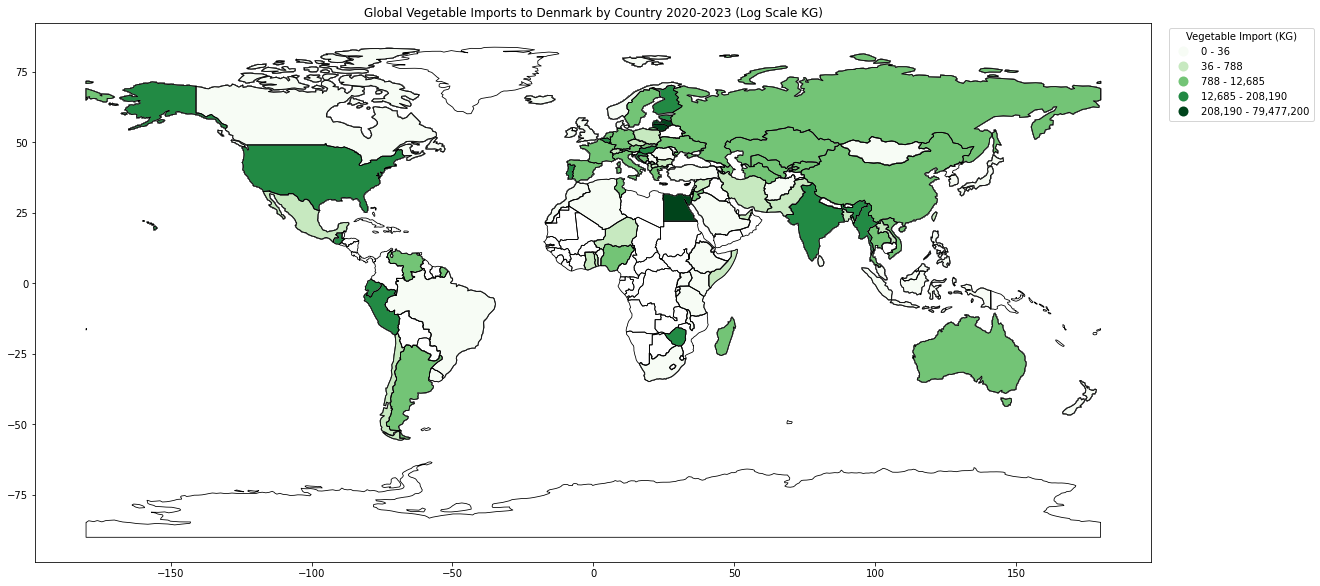

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import mapclassify as mc

# Remove missing values and zero imports
gdf_clean = gdf.dropna(subset=["geometry", "KG"])
gdf_clean = gdf_clean[gdf_clean["KG"] > 0]

# Apply log transformation
gdf_clean["log_KG"] = np.log1p(gdf_clean["KG"])  # log(1+KG) to handle zero cases

# Define classification on log values
classifier = mc.NaturalBreaks(gdf_clean["log_KG"], k=5)  # Using Jenks for natural groupings

# Plot choropleth
fig, ax = plt.subplots(figsize=(20, 12))
gdf_clean.plot(column="log_KG", cmap="Greens", legend=True, edgecolor="gray",
               scheme="natural_breaks", classification_kwds={"k": 5}, ax=ax)

# Customize legend labels with actual KG values
bin_edges = np.exp(classifier.bins)  # Reverse log transformation to get real-world values
legend_labels = [f"{int(low):,} - {int(high):,}" for low, high in zip([0] + bin_edges[:-1].tolist(), bin_edges.tolist())]

# Move legend outside the plot
leg = ax.get_legend()
leg.set_title("Vegetable Import (KG)")
leg.set_bbox_to_anchor((1.15, 1))  # Move legend to the right outside the plot
for text, label in zip(leg.get_texts(), legend_labels):
    text.set_text(label)  # Replace log values with real KG values

# Add natural Earth coastlines and country borders**
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))  # Load world borders
world.boundary.plot(ax=ax, edgecolor="black", linewidth=0.8)  # Add country borders

plt.title("Global Vegetable Imports to Denmark by Country 2020-2023 (Log Scale KG)")
plt.show()
